<a href="https://colab.research.google.com/github/amelia188/DataScience/blob/master/LSTM_SoilMoisture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

In this script, I took the LSTM and tried to make it a series of functions that we could run quickly and change different varaibles easily. So there are a series of functions to prepare the data, and the LSTM is a class, with functions within it to plot the history of losses and scatter plots. It's almost like a pipeline for MLPs except for an LSTM (because there is no pipeline object for LSTMs in scikit-learn, since it doesn't support the reshaping operations needed for LSTMs directly). It's a custom pipeline process for our LSTM problem.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#new lstm from Dr Payne

from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# Load the dataset
df = pd.read_excel("/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/Merged Soil Moisture & Weather Data.xlsx")

# Remove rows with missing or non-numeric data
df_clean = df.apply(pd.to_numeric, errors='coerce')
df_clean.dropna(inplace=True)

In [ ]:
# split into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
def prepare_data(Y, past_steps, future_steps):
    scaler = MinMaxScaler(feature_range=(0, 1))
    Y_scaled = scaler.fit_transform(Y)
    X, y = split_sequence(Y_scaled, past_steps, future_steps)
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y, scaler


In [ ]:
def build_lstm_model(n_steps_in, n_features, n_steps_out):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
class LSTMPipeline:
    def __init__(self, past_steps, future_steps):
        self.past_steps = past_steps
        self.future_steps = future_steps
        self.scaler = None
        self.model = None

    def fit(self, Y):
        X, y, self.scaler = prepare_data(Y, self.past_steps, self.future_steps)
        self.model = build_lstm_model(self.past_steps, 1, self.future_steps)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.history = self.model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=2)
        return self

    def predict(self, Y):
        X, _, _ = prepare_data(Y, self.past_steps, self.future_steps)  # Only use X for prediction
        predictions = self.model.predict(X, verbose=0)
        predictions_unscaled = self.scaler.inverse_transform(predictions.reshape(-1, 1))
        return predictions_unscaled

    def plot_history(self):
        plt.plot(self.history.history['loss'], label='Training Loss', marker='*')
        plt.plot(self.history.history['val_loss'], label='Validation Loss', marker='.')
        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.legend()
        plt.show()

    def plot_actual_vs_predicted(self, Y):
        X, y, _ = prepare_data(Y, self.past_steps, self.future_steps)  # Reuse Y for splitting, no need for scaler here
        predictions = self.model.predict(X, verbose=0)
        # Reshape if predictions are for more than one step
        if predictions.ndim > 2:
            predictions = predictions[:, -1, :]
        predictions_unscaled = self.scaler.inverse_transform(predictions)
        actual_unscaled = self.scaler.inverse_transform(y.reshape(-1, 1))
        plt.figure(figsize=(10, 5))
        plt.scatter(range(len(actual_unscaled)), actual_unscaled, marker='d', markersize=1, label='Actual')
        plt.scatter(range(len(predictions_unscaled)), predictions_unscaled, marker='.', markersize=3, label='Predicted')
        plt.title('Actual vs Predicted Soil Moisture')
        plt.xlabel('Time Steps')
        plt.ylabel('Soil Moisture')
        plt.legend()
        plt.show()
'''
    def plot_actual_vs_predicted_scatter(self, Y_original):
        # First, prepare the data and generate predictions for the entire dataset
        # Ensure Y_original is your complete dataset similar to what X was derived from
        X, _, _ = prepare_data(Y_original, self.past_steps, self.future_steps)
        predictions = self.model.predict(X, verbose=0)

        # Adjust below if predictions are for multi-step and you want to compare a specific time step
        if predictions.ndim > 2:
            predictions = predictions[:, -1, :]

        # Inverse transform to convert back to original scale
        predictions_unscaled = self.scaler.inverse_transform(predictions)

        # You must ensure Y_original matches how you extracted Y from the full dataset initially
        # Slice Y_original to match the reduced size due to sequence creation if necessary
        actual_unscaled = self.scaler.inverse_transform(Y_original.reshape(-1, 1))[self.past_steps: -self.future_steps]  # Adjust based on sequence overlap and prediction steps

        # Plotting the scatter plot
        plt.figure(figsize=(8, 8))
        plt.scatter(actual_unscaled.flatten(), predictions_unscaled.flatten(), marker='*')  # Flattening if needed
        plt.xlabel('Actual Soil Moisture')
        plt.ylabel('Predicted Soil Moisture')
        plt.title('Actual vs Predicted Soil Moisture')
        plt.grid(True)
        plt.show()
'''

For the experiment using the LSTM pipeline I wanted to see if it could predict past data. So I set the future_steps variable (or steps ahead) to 1. This allows us to plot the comparison graphs between predicted and measured values (because the output will have the same shape as the input). In the next code section I trained the LSTM on SH1 Node: Soil Moisture 4 in - bar.

In [ ]:
Y = df_clean[['SH1 Node: Soil Moisture 4 in - bar']].values  # Assuming this is your target variable
lstm_pipeline = LSTMPipeline(past_steps=24, future_steps=1)
lstm_pipeline.fit(Y)
predictions = lstm_pipeline.predict(Y)  # Predict on the same data for simplicity, or replace Y with new data

Epoch 1/100
108/108 - 8s - loss: 0.0205 - val_loss: 0.0014 - 8s/epoch - 75ms/step
Epoch 2/100
108/108 - 6s - loss: 0.0018 - val_loss: 0.0013 - 6s/epoch - 53ms/step
Epoch 3/100
108/108 - 5s - loss: 0.0013 - val_loss: 4.9405e-04 - 5s/epoch - 42ms/step
Epoch 4/100
108/108 - 4s - loss: 0.0018 - val_loss: 8.7396e-04 - 4s/epoch - 41ms/step
Epoch 5/100
108/108 - 6s - loss: 0.0011 - val_loss: 3.4111e-04 - 6s/epoch - 54ms/step
Epoch 6/100
108/108 - 4s - loss: 9.8524e-04 - val_loss: 3.4117e-04 - 4s/epoch - 36ms/step
Epoch 7/100
108/108 - 4s - loss: 8.9427e-04 - val_loss: 3.5751e-04 - 4s/epoch - 42ms/step
Epoch 8/100
108/108 - 6s - loss: 6.8460e-04 - val_loss: 1.7970e-04 - 6s/epoch - 52ms/step
Epoch 9/100
108/108 - 4s - loss: 6.1544e-04 - val_loss: 1.8836e-04 - 4s/epoch - 40ms/step
Epoch 10/100
108/108 - 5s - loss: 6.7136e-04 - val_loss: 1.3591e-04 - 5s/epoch - 44ms/step
Epoch 11/100
108/108 - 5s - loss: 6.4572e-04 - val_loss: 1.7075e-04 - 5s/epoch - 47ms/step
Epoch 12/100
108/108 - 4s - loss: 5.

Next we plot the loss history and the actual vs predicted soil moisture time series.

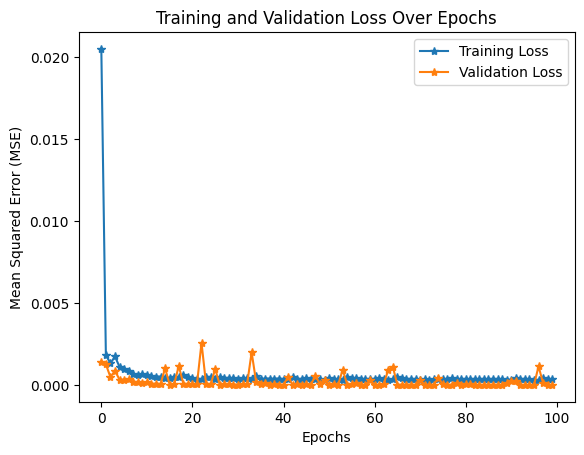

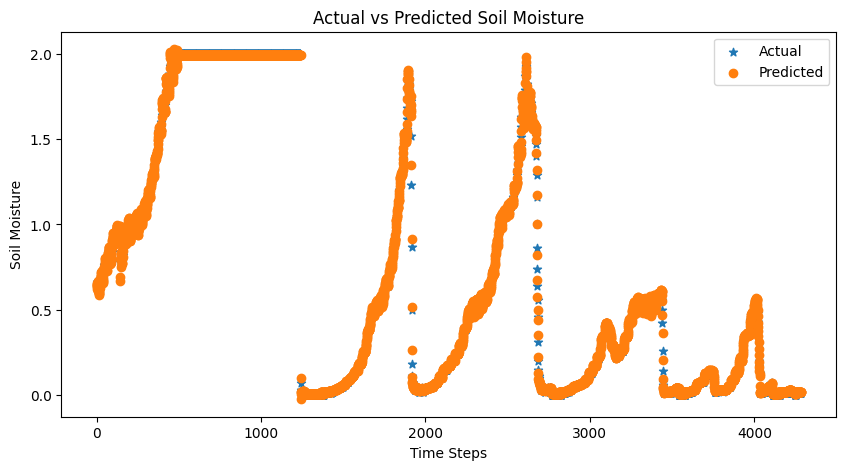

In [ ]:
lstm_pipeline.plot_history()
lstm_pipeline.plot_actual_vs_predicted(Y)
#lstm_pipeline.plot_actual_vs_predicted_scatter(Y)

Predicting SH1 20in node.

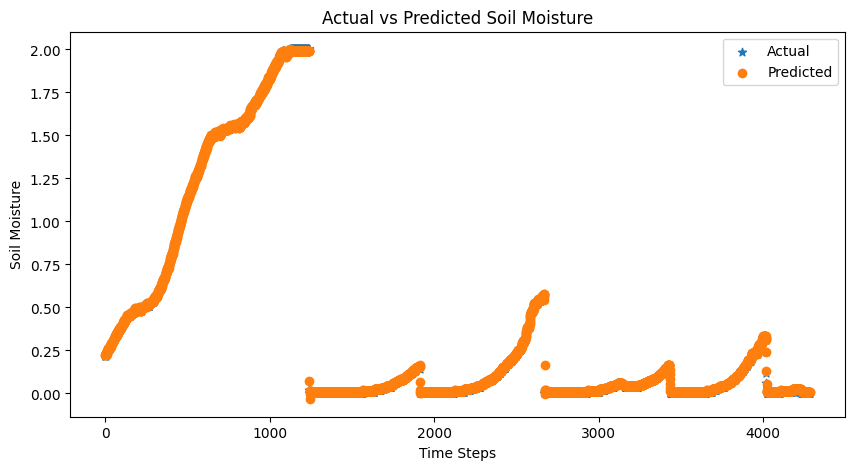

In [ ]:
Y_SH_20 = df_clean[['SH1 Node: Soil Moisture 20 in - bar']].values  # Assuming this is your target variable
new_predictions = lstm_pipeline.predict(Y_SH_20)  # Predict on the same data for simplicity, or replace Y with new data
lstm_pipeline.plot_actual_vs_predicted(Y_SH_20)

Importing new data and predicting SH1 36in data.

In [ ]:
# Adjust the path to where you've saved your new data file
new_data_path = '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/Merged Soil Moisture & Weather Data 31Jan2024.xlsx'
new_data = pd.read_excel(new_data_path)

# Remove rows with missing or non-numeric data
new_data_clean = new_data.apply(pd.to_numeric, errors='coerce')
new_data_clean.dropna(inplace=True)

In [ ]:
Y_new = new_data_clean[['SH1 Node: Soil Moisture 36 in - bar']].values  # Assuming this is your target variable
#prepare_data(Y_new, past_steps=24, future_steps=1)
new_predictions = lstm_pipeline.predict(Y_new)  # Predict on the same data for simplicity, or replace Y with new data

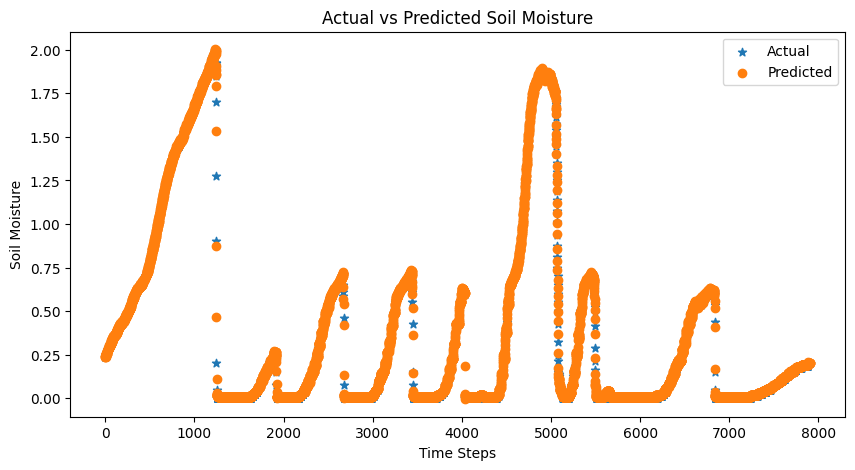

In [ ]:
lstm_pipeline.plot_actual_vs_predicted(Y_new)
#lstm_pipeline.plot_actual_vs_predicted_scatter(Y)

Just testing out the scatter plot below.

In [ ]:
# Adjust the length of new_predictions to match the length of new_data_clean
new_predictions = np.concatenate((new_predictions, np.zeros((24, 1))), axis=0)
#new_predictions = new_predictions[:-24]

In [ ]:
plt.figure(figsize=[8,8])
plt.scatter(new_data_clean['SH1 Node: Soil Moisture 4 in - bar'], new_data_clean['Predicted Soil Moisture'], alpha=0.5)
plt.title('Actual vs Predicted Soil Moisture')
plt.xlabel('SH1 Node: Soil Moisture 4 in - bar')
plt.ylabel('Predicted Soil Moisture')
plt.plot([new_data_clean['SH1 Node: Soil Moisture 4 in - bar'].min(), new_data_clean['SH1 Node: Soil Moisture 4 in - bar'].max()],
         [new_data_clean['SH1 Node: Soil Moisture 4 in - bar'].min(), new_data_clean['SH1 Node: Soil Moisture 4 in - bar'].max()],
         'r--')  # Adds a reference line for perfect predictions
plt.grid(True)
plt.show()
